# Set-Up

In [1]:
import jax
import jax.numpy as jnp
from approx_post.distributions import approx, joint, amortised
from approx_post import losses, optimisers
import seaborn as sns
import matplotlib.pyplot as plt
from arraytainers import Jaxtainer
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

# Plotting Functions

In [2]:
def plot_data(data, true_theta, model):
    sns.scatterplot(x=true_theta.squeeze(), y=data.squeeze(), label=f"Obsevations")
    sns.lineplot(x=true_theta.squeeze(), y=model(true_theta).squeeze(), label=f"True Relationship", color='r')
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("(Noisy) Observations $x$")
    plt.show()

In [3]:
def plot_phi_function(amortised_dist, x, x_obs=None, true_theta=None, model=None):
    if x.ndim < 2:
        x = x[:,None]
    pred_phi = amortised_dist.phi(x)
    pred_mean, pred_cov = pred_phi['mean'].squeeze(), jnp.exp(pred_phi['log_chol_diag']).squeeze()**2
    mean_plus_cov = pred_mean + pred_cov
    mean_minus_cov = pred_mean - pred_cov
    
    x_plt = x.squeeze()
    ax = sns.lineplot(x=x_plt, y=pred_mean, label=f"Predicted Mean", color='red')
    sns.lineplot(x=x_plt, y=mean_plus_cov, color='red', label=f"Predicted Mean Plus/Minus Predicted Variance", linestyle='--')
    sns.lineplot(x=x_plt, y=mean_minus_cov, color='red', linestyle='--')
    ax.fill_between(x_plt, mean_minus_cov, mean_plus_cov, color="red", alpha=0.2)
    if (data is not None) and (true_theta is not None):
        sns.scatterplot(x=data.squeeze(), y=true_theta.squeeze(), label=f"Observations") 
    if (model is not None) and (true_theta is not None):
        sns.scatterplot(x=model(true_theta.squeeze()), y=true_theta.squeeze(), label=f"True Relationship", color='g')
    plt.xlabel("Observation $x$")
    plt.ylabel("Parameter $\Theta$")
    plt.show()

In [4]:
def plot_posteriors(ammortised_dist, x_list, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-3, 3, 1000)).reshape(1,-1,1)
    for x_i in x_list:
        pdf = jnp.exp(amortised_dist.logpdf(theta, x=jnp.array([[x_i]])))
        ax = sns.lineplot(x=theta.squeeze(), y=pdf.squeeze(), label=f"x = {x_i:.1f}")
        ax.fill_between(theta.squeeze(), pdf.squeeze(), alpha=0.2)
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("Posterior Probability Density")

# Artificial Data Creation

In [5]:
def create_data(model, theta, noise_cov, prngkey):
    num_batch = theta.shape[0] 
    mean_vals = model(theta).reshape(num_batch, -1) # shape = (num_batch, dim_theta)
    # Zero-mean samples:
    x_dim = mean_vals.shape[1]
    epsilon = jax.random.multivariate_normal(prngkey, mean=jnp.zeros(x_dim), cov=noise_cov, shape=(num_batch,)) # shape = (num_batch, dim_x)
    # Add each mean on:
    samples = mean_vals + epsilon # shape = (num_batch, x_dim)
    return samples

In [6]:
# Define model:
ndim = 1
model = lambda theta: theta**2
model_grad = jax.vmap(jax.vmap(jax.jacfwd(model), in_axes=0), in_axes=0)

In [26]:
prngkey = jax.random.PRNGKey(42)
num_batch = 100
true_theta = jnp.linspace(-5, 5, 100)
num_batch = 100
noise_cov = 1*jnp.identity(ndim)
data = create_data(model, true_theta, noise_cov, prngkey)

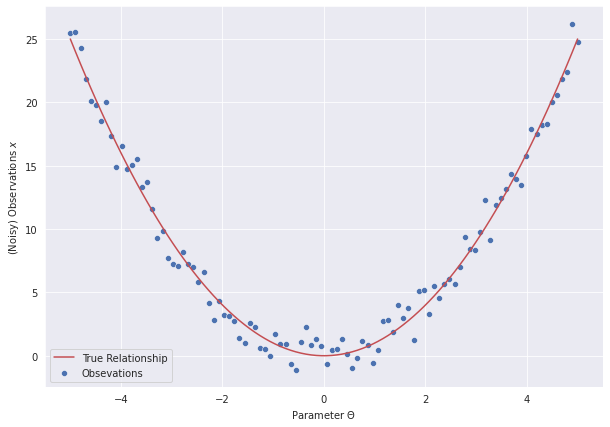

In [27]:
plot_data(data, true_theta, model)

# Create Joint Distribution

In [28]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
noise_cov = jnp.identity(ndim)
joint_dist = joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

# Neural Network

In [29]:
prngkey = jax.random.PRNGKey(10)
approx_dist = approx.Gaussian(ndim)
preprocessing = amortised.Preprocessing.std_scaling(data)
amortised_dist = amortised.NeuralNetwork(approx_dist, ndim, prngkey, num_layers=3, width=10, \
                                         activation='sigmoid', preprocessing=preprocessing)

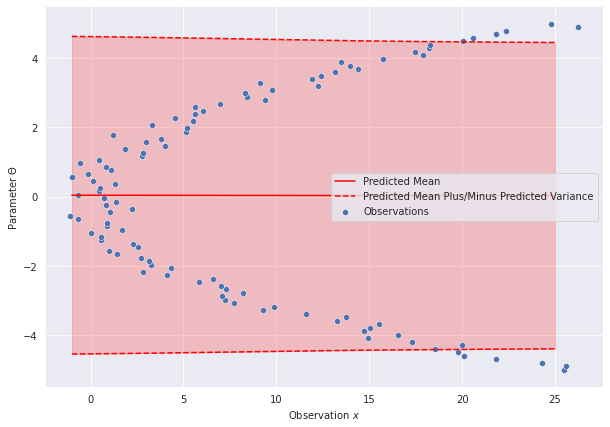

In [30]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [13]:
# Initialise:
target = Jaxtainer({'mean': 0*data, 'log_chol_diag': jnp.zeros(data.shape)})
mse = losses.MSE(target)
optimiser = optimisers.Adam(lr=1e-3)
optimiser.fit(amortised_dist, mse, data, prngkey, verbose=True)

Loss = 57.076255798339844
Loss = 54.95320129394531
Loss = 52.893001556396484
Loss = 50.89548110961914
Loss = 48.95883560180664
Loss = 47.07907485961914
Loss = 45.25035858154297
Loss = 43.46721649169922
Loss = 41.7263298034668
Loss = 40.02660369873047
Loss = 38.368194580078125
Loss = 36.75182342529297
Loss = 35.17826843261719
Loss = 33.64823532104492
Loss = 32.16230010986328
Loss = 30.720827102661133
Loss = 29.324039459228516
Loss = 27.97195816040039
Loss = 26.66443634033203
Loss = 25.401165008544922
Loss = 24.181673049926758
Loss = 23.005361557006836
Loss = 21.87150764465332
Loss = 20.77933120727539
Loss = 19.72795867919922
Loss = 18.716508865356445
Loss = 17.744123458862305
Loss = 16.809921264648438
Loss = 15.913077354431152
Loss = 15.052781105041504
Loss = 14.228250503540039
Loss = 13.438695907592773
Loss = 12.683332443237305
Loss = 11.961341857910156
Loss = 11.271882057189941
Loss = 10.61406421661377
Loss = 9.986974716186523
Loss = 9.389660835266113
Loss = 8.821142196655273
Loss = 8

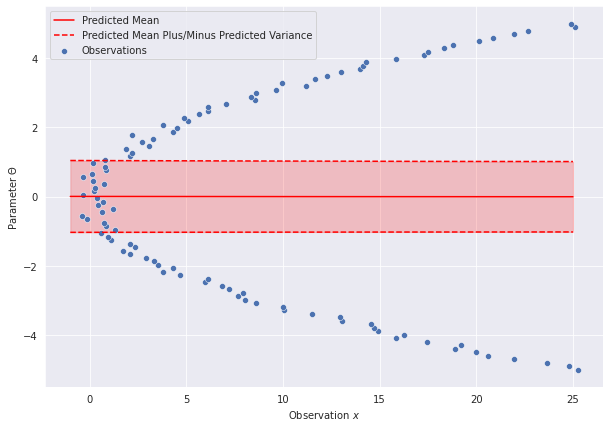

In [14]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [35]:
prngkey = jax.random.PRNGKey(20)
loss = losses.ReverseKL(joint_dist, use_reparameterisation=True)
optimiser = optimisers.Adam()
optimiser.fit(amortised_dist, loss, data, prngkey, verbose=True, num_samples=1000, max_iter=200)

Loss = 6.516937255859375
Loss = 44.87244415283203
Loss = 10.696911811828613
Loss = 47.54931640625
Loss = 14.705718994140625
Loss = 7.744267463684082
Loss = 16.994979858398438
Loss = 22.530487060546875
Loss = 22.194286346435547
Loss = 17.90283203125
Loss = 12.32119369506836
Loss = 8.556862831115723
Loss = 8.6553316116333
Loss = 11.550951957702637
Loss = 13.726943016052246
Loss = 13.084479331970215
Loss = 10.735231399536133
Loss = 8.758407592773438
Loss = 8.148648262023926
Loss = 8.68346881866455
Loss = 9.60151481628418
Loss = 10.243401527404785
Loss = 10.293107986450195
Loss = 9.764581680297852
Loss = 8.915278434753418
Loss = 8.128692626953125
Loss = 7.745418548583984
Loss = 7.863372802734375
Loss = 8.242426872253418
Loss = 8.463699340820312
Loss = 8.267195701599121
Loss = 7.762409687042236
Loss = 7.29686975479126
Loss = 7.137948036193848
Loss = 7.29245138168335
Loss = 7.565192699432373
Loss = 7.730387210845947
Loss = 7.670767784118652
Loss = 7.42389440536499
Loss = 7.138340950012207
Lo

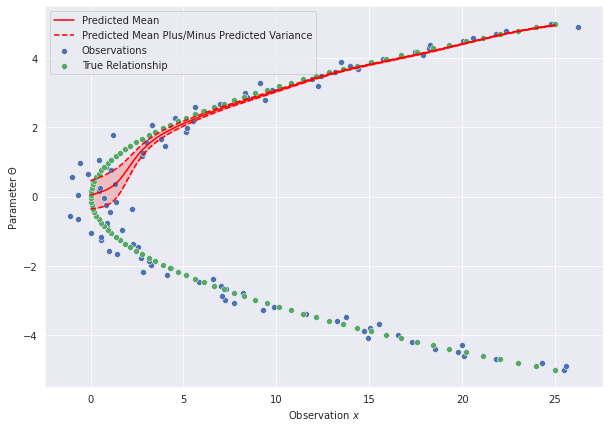

In [36]:
x_plt = jnp.linspace(0,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta, model)

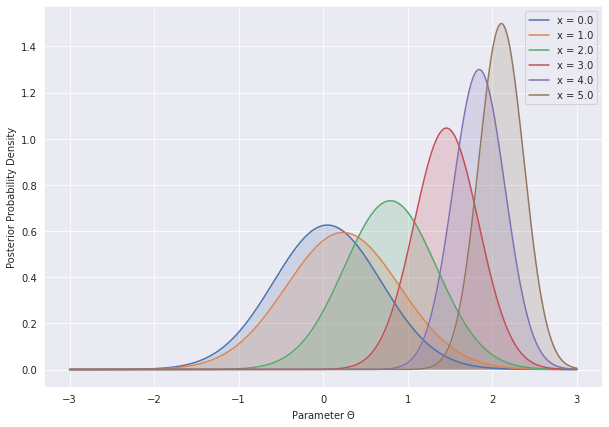

In [37]:
x_vals = [0, 1, 2, 3, 4, 5]
plot_posteriors(amortised_dist, x_vals)

# Linear Regression

In [94]:
prngkey = jax.random.PRNGKey(10)
approx_dist = approx.Gaussian(ndim)
preprocessing = amortised.Preprocessing.range_scaling(data)
amortised_dist = amortised.LinearRegression(approx_dist, ndim, prngkey, order=20, preprocessing=preprocessing)

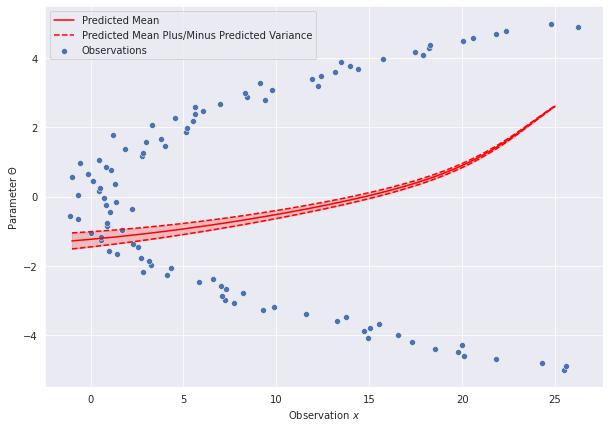

In [95]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [96]:
amortised_dist.initialise(data)

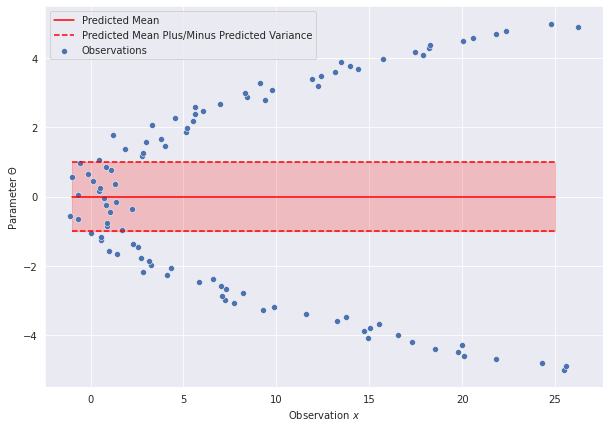

In [97]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [98]:
prngkey = jax.random.PRNGKey(42)
loss = losses.ReverseKL(joint_dist, use_reparameterisation=True)
optimiser = optimisers.Adam()
optimiser.fit(amortised_dist, loss, data, prngkey, verbose=True, num_samples=1000, max_iter=200)

Loss = 59.435672760009766
Loss = 128.6910400390625
Loss = 56.883602142333984
Loss = 60.76547622680664
Loss = 60.57522964477539
Loss = 58.06157684326172
Loss = 53.54672622680664
Loss = 48.17335510253906
Loss = 44.73500061035156
Loss = 46.13175582885742
Loss = 49.40176773071289
Loss = 48.22307205200195
Loss = 43.17081832885742
Loss = 37.78675842285156
Loss = 34.016357421875
Loss = 31.749900817871094
Loss = 30.03757095336914
Loss = 28.096158981323242
Loss = 25.598100662231445
Loss = 22.594451904296875
Loss = 19.392189025878906
Loss = 16.45685577392578
Loss = 14.28992748260498
Loss = 13.22613525390625
Loss = 13.196332931518555
Loss = 13.688199043273926
Loss = 14.111220359802246
Loss = 14.255900382995605
Loss = 14.312980651855469
Loss = 14.543560028076172
Loss = 15.04637622833252
Loss = 15.758285522460938
Loss = 16.555286407470703
Loss = 17.329843521118164
Loss = 18.01698112487793
Loss = 18.59014892578125
Loss = 19.048337936401367
Loss = 19.40529441833496
Loss = 19.68288230895996
Loss = 19.

KeyboardInterrupt: 

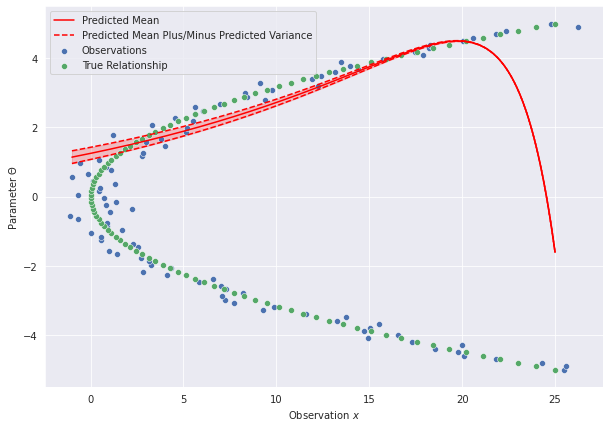

In [99]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta, model)

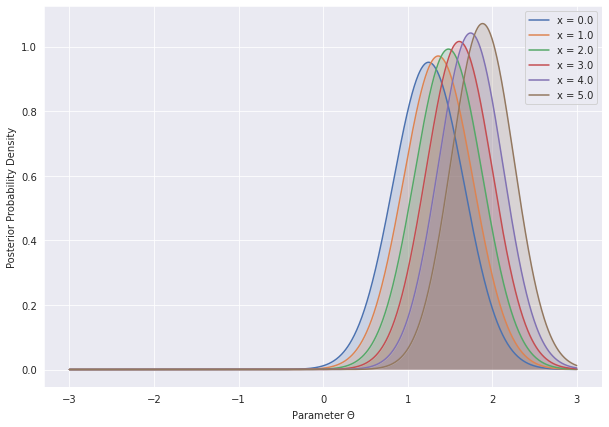

In [100]:
x_vals = [0, 1, 2, 3, 4, 5]
plot_posteriors(amortised_dist, x_vals)